In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import open_clip
from typing import Optional, List, Tuple, Dict

In [2]:
class TimeSeriesDataset(Dataset):
    """Dataset for time series anomaly detection"""
    def __init__(self, data: np.ndarray, window_size: int = 224):
        self.data = data
        self.window_size = window_size
        
    def __len__(self):
        return len(self.data) - self.window_size + 1
    
    def __getitem__(self, idx):
        window = self.data[idx:idx + self.window_size]
        return torch.FloatTensor(window), idx


def time_series_to_image(series: np.ndarray, img_size: int = 224) -> torch.Tensor:
    """Render multivariate time-series window (L,C) into RGB image tensor (3,H,W) scaled [0,1]."""
    if series.ndim == 1:
        series = series.reshape(-1, 1)

    L, C = series.shape
    fig, ax = plt.subplots(figsize=(img_size / 100, img_size / 100), dpi=100)
    colors = plt.cm.tab10(np.linspace(0, 1, max(10, C)))
    for i in range(C):
        ax.plot(series[:, i], linewidth=1.2, color=colors[i % len(colors)], alpha=0.9)

    ax.set_xlim(0, L - 1)
    ax.set_ylim(series.min(), series.max())
    ax.axis("off")
    ax.margins(0, 0)
    fig.tight_layout(pad=0)

    buf = BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0)
    plt.close(fig)
    buf.seek(0)

    img = Image.open(buf).convert("RGB")
    img = img.resize((img_size, img_size), Image.LANCZOS)
    img_array = np.array(img).astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(img_array).permute(2, 0, 1)
    return img_tensor


class ViT4TS(nn.Module):
    """
    Visual Time Series Anomaly Screening using pretrained ViT
    (Following the VLM4TS paper architecture)
    """
    def __init__(
        self,
        model_name: str = 'ViT-B-16',
        pretrained: str = 'laion400m_e32',
        img_size: int = 224,
        multi_scale_kernels: List[int] = [2, 3]
    ):
        super().__init__()
        
        self.img_size = img_size
        self.multi_scale_kernels = multi_scale_kernels
        
        # Load pretrained CLIP vision encoder
        model, _, preprocess = open_clip.create_model_and_transforms(
            model_name,
            pretrained=pretrained
        )
        
        self.vision_encoder = model.visual
        
        # Freeze all parameters (zero-shot)
        for param in self.vision_encoder.parameters():
            param.requires_grad = False
        
        self.vision_encoder.eval()
        
        # Get embedding dimension
        if hasattr(self.vision_encoder, 'output_dim'):
            self.embed_dim = self.vision_encoder.output_dim
        else:
            self.embed_dim = 768  
    
    def extract_patch_features(self, images: torch.Tensor) -> torch.Tensor:
        """
        Extract patch-level features from the penultimate layer
        
        Args:
            images: (batch, 3, H, W)
        
        Returns:
            patch_features: (batch, num_patches, embed_dim)
        """
        # Pass through vision encoder blocks
        x = self.vision_encoder.conv1(images)  # Patch embedding
        x = x.reshape(x.shape[0], x.shape[1], -1)  # (B, D, num_patches)
        x = x.permute(0, 2, 1)  # (B, num_patches, D)
        
        # Add positional embedding
        if hasattr(self.vision_encoder, 'class_embedding'):
            class_embed = self.vision_encoder.class_embedding.expand(x.shape[0], 1, -1)
            x = torch.cat([class_embed, x], dim=1)
        
        if hasattr(self.vision_encoder, 'positional_embedding'):
            x = x + self.vision_encoder.positional_embedding[:x.shape[1], :]
        
        # Pre-norm
        if hasattr(self.vision_encoder, 'ln_pre'):
            x = self.vision_encoder.ln_pre(x)
        
        # Pass through transformer blocks
        for block in self.vision_encoder.transformer.resblocks:
            x = block(x)
        
        # Remove class token if present
        if hasattr(self.vision_encoder, 'class_embedding'):
            x = x[:, 1:, :]
        
        return x
    
    def multi_scale_pooling(self, features: torch.Tensor) -> List[torch.Tensor]:
        """
        Apply multi-scale average pooling on patch features
        
        Args:
            features: (batch, num_patches, embed_dim)
        
        Returns:
            List of pooled features at different scales
        """
        batch_size, num_patches, embed_dim = features.shape
        
        # Reshape to 2D grid (assuming square patch layout)
        grid_size = int(np.sqrt(num_patches))
        features_2d = features.reshape(batch_size, grid_size, grid_size, embed_dim)
        features_2d = features_2d.permute(0, 3, 1, 2)  # (B, D, H, W)
        
        pooled_features = [features]  # Base scale
        
        for kernel_size in self.multi_scale_kernels:
            pooled = F.avg_pool2d(
                features_2d,
                kernel_size=kernel_size,
                stride=1,
                padding=0
            )
            # Flatten back to sequence
            pooled = pooled.permute(0, 2, 3, 1)  # (B, H', W', D)
            pooled = pooled.reshape(batch_size, -1, embed_dim)
            pooled_features.append(pooled)
        
        return pooled_features
    
    def cross_patch_comparison(
        self,
        features_list: List[torch.Tensor],
        reference_features_list: List[torch.Tensor]
    ) -> torch.Tensor:
        """
        Compute cross-patch dissimilarity scores using median reference
        
        Args:
            features_list: Multi-scale features for test window
            reference_features_list: Multi-scale features for all windows
        
        Returns:
            Anomaly scores for each patch
        """
        scores = []
        
        for scale_idx, test_features in enumerate(features_list):
            ref_features = reference_features_list[scale_idx]
            
            # Compute median reference
            median_ref = torch.median(ref_features, dim=0, keepdim=True)[0]
            
            # Normalize for cosine similarity
            test_norm = F.normalize(test_features, p=2, dim=-1)
            ref_norm = F.normalize(median_ref, p=2, dim=-1)
            
            # Compute dissimilarity (1 - cosine similarity)
            similarity = torch.matmul(test_norm, ref_norm.transpose(-2, -1))
            dissimilarity = 1 - similarity.max(dim=-1)[0]
            
            scores.append(dissimilarity)
        
        # Harmonic mean across scales
        harmonic_scores = len(scores) / sum(1.0 / (s + 1e-8) for s in scores)
        
        return harmonic_scores.mean(dim=-1)  # Average across patches
    
    def forward(self, images: torch.Tensor) -> torch.Tensor:
        """
        Extract features for anomaly detection
        
        Args:
            images: (batch, 3, H, W)
        
        Returns:
            features: (batch, num_patches, embed_dim)
        """
        with torch.no_grad():
            features = self.extract_patch_features(images)
        return features


class PrototypeAttention(nn.Module):
    """Attention mechanism with prototypes"""
    def __init__(self, d_model: int, num_heads: int):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_model)
        
    def forward(self, x, prototype):
        batch_size, seq_len, _ = x.shape
        
        # Compute queries, keys, values for input
        q_x = self.q_linear(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim)
        k_x = self.k_linear(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim)
        v_x = self.v_linear(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim)
        
        # Compute keys, values for prototype
        k_p = self.k_linear(prototype).reshape(batch_size, seq_len, self.num_heads, self.head_dim)
        v_p = self.v_linear(prototype).reshape(batch_size, seq_len, self.num_heads, self.head_dim)
        
        # Transpose for attention computation
        q_x = q_x.transpose(1, 2)  # (batch, heads, seq, head_dim)
        k_x = k_x.transpose(1, 2)
        v_x = v_x.transpose(1, 2)
        k_p = k_p.transpose(1, 2)
        v_p = v_p.transpose(1, 2)
        
        # Compute attention scores
        scale = self.head_dim ** -0.5
        attn_x = torch.matmul(q_x, k_x.transpose(-2, -1)) * scale
        attn_p = torch.matmul(q_x, k_p.transpose(-2, -1)) * scale
        
        # Combine attention scores
        attn = torch.cat([attn_x, attn_p], dim=-1)
        attn = F.softmax(attn, dim=-1)
        
        # Split attention weights
        attn_x = attn[:, :, :, :seq_len]
        attn_p = attn[:, :, :, seq_len:]
        
        # Apply attention
        out = torch.matmul(attn_x, v_x) + torch.matmul(attn_p, v_p)
        
        # Reshape and project
        out = out.transpose(1, 2).reshape(batch_size, seq_len, self.d_model)
        out = self.out_linear(out)
        
        return out


class PrototypeTransformerBlock(nn.Module):
    """Transformer block with prototype attention"""
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        self.attention = PrototypeAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 4, d_model),
            nn.Dropout(dropout)
        )
        
    def forward(self, x, prototype):
        # Attention with residual
        attn_out = self.attention(x, prototype)
        x = self.norm1(x + attn_out)
        
        # FFN with residual
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        
        return x


class StudentNetwork(nn.Module):
    """Prototype-based Transformer Encoder Student Network"""
    def __init__(
        self,
        window_size: int,
        num_channels: int = 1,
        d_model: int = 64,
        num_heads: int = 8,
        num_layers: int = 3,
        num_prototypes: int = 32,
        patch_size: int = 16,
        dropout: float = 0.1
    ):
        super().__init__()
        self.window_size = window_size
        self.num_channels = num_channels
        self.patch_size = patch_size
        self.d_model = d_model
        self.num_prototypes = num_prototypes
        
        self.num_patches = window_size // patch_size
        
        # Patch embedding (handles multiple channels)
        self.patch_embed = nn.Linear(patch_size * num_channels, d_model)
        
        # Positional embedding
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, d_model))
        
        # Prototype pool (one set per channel)
        self.prototypes = nn.Parameter(torch.randn(num_channels, num_prototypes, window_size))
        
        # Transformer blocks with prototype attention
        self.blocks = nn.ModuleList([
            PrototypeTransformerBlock(d_model, num_heads, dropout)
            for _ in range(num_layers)
        ])
        
        # Output projection
        self.norm = nn.LayerNorm(d_model)
        self.output = nn.Linear(self.num_patches * d_model, d_model)
        
    def select_prototype(self, x: torch.Tensor) -> torch.Tensor:
        """Select most similar prototype using cosine similarity"""
        batch_size = x.shape[0]
        
        if self.num_channels == 1:
            # Univariate case
            x_norm = F.normalize(x, dim=-1)
            proto_norm = F.normalize(self.prototypes[0], dim=-1)
            similarity = torch.matmul(x_norm, proto_norm.T)
            idx = torch.argmax(similarity, dim=-1)
            selected = self.prototypes[0][idx]
        else:
            # Multivariate case - select per channel and concatenate
            x_reshaped = x.reshape(batch_size, self.num_channels, -1)
            selected_list = []
            
            for c in range(self.num_channels):
                x_c = x_reshaped[:, c, :]
                x_norm = F.normalize(x_c, dim=-1)
                proto_norm = F.normalize(self.prototypes[c], dim=-1)
                similarity = torch.matmul(x_norm, proto_norm.T)
                idx = torch.argmax(similarity, dim=-1)
                selected_list.append(self.prototypes[c][idx])
            
            selected = torch.cat(selected_list, dim=1)
        
        return selected
    
    def patchify(self, x: torch.Tensor) -> torch.Tensor:
        """Convert time series to patches"""
        batch_size = x.shape[0]
        
        if self.num_channels == 1:
            # Univariate: (batch, window_size)
            x = x[:, :self.num_patches * self.patch_size]
            x = x.reshape(batch_size, self.num_patches, self.patch_size)
        else:
            # Multivariate: (batch, window_size * num_channels)
            x = x[:, :self.num_patches * self.patch_size * self.num_channels]
            x = x.reshape(batch_size, self.num_channels, self.num_patches, self.patch_size)
            x = x.permute(0, 2, 1, 3)  # (batch, num_patches, num_channels, patch_size)
            x = x.reshape(batch_size, self.num_patches, -1)  # Flatten channels and patch_size
        
        return x
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (batch, window_size) for univariate or (batch, window_size * num_channels) for multivariate
        Returns:
            features: (batch, d_model)
        """
        # Select prototype
        prototype = self.select_prototype(x)
        
        # Patchify input and prototype
        x_patches = self.patchify(x)
        p_patches = self.patchify(prototype)
        
        # Embed patches
        x_embed = self.patch_embed(x_patches)
        p_embed = self.patch_embed(p_patches)
        
        # Add positional embedding
        x_embed = x_embed + self.pos_embed
        p_embed = p_embed + self.pos_embed
        
        # Apply transformer blocks with prototypes
        for block in self.blocks:
            x_embed = block(x_embed, p_embed)
        
        # Normalize and pool
        x_embed = self.norm(x_embed)
        x_flat = x_embed.reshape(x_embed.shape[0], -1)
        output = self.output(x_flat)
        
        return output


class AnomalyLLMViT(nn.Module):
    """
    Complete anomaly detection system combining:
    1. ViT4TS: Visual screening stage (Teacher)
    2. Prototype-based Transformer Encoder (Student)
    """
    def __init__(
        self,
        window_size: int = 224,
        num_channels: int = 1,
        stride: int = 56,
        d_model: int = 64,
        num_heads: int = 8,
        num_layers: int = 3,
        num_prototypes: int = 32,
        patch_size: int = 16,
        threshold_quantile: float = 0.75
    ):
        super().__init__()
        
        self.window_size = window_size
        self.num_channels = num_channels
        self.stride = stride
        self.threshold_quantile = threshold_quantile
        teacher_dim = 768
        hidden_dim = 64  

        # Teacher projection
        self.teacher_proj = nn.Linear(teacher_dim, hidden_dim)

        # Teacher network: ViT4TS
        self.teacher = ViT4TS(
            model_name='ViT-B-16',
            pretrained='laion400m_e32',
            img_size=window_size
        )
        
        self.teacher_adapter = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.1)
        )
        
        # Student network: Prototype-based Transformer
        self.student = StudentNetwork(
            window_size=window_size,
            num_channels=num_channels,
            d_model=d_model,
            num_heads=num_heads,
            num_layers=num_layers,
            num_prototypes=num_prototypes,
            patch_size=patch_size
        )

        # Ensure teacher.img_size exists and matches time_series_to_image output
        teacher_img_size = getattr(self.teacher, "img_size", 224)

        dummy = torch.randn(1, 3, teacher_img_size, teacher_img_size).to(
            next(self.teacher.parameters()).device
        )
        with torch.no_grad():
            teacher_out = self.teacher(dummy)

        teacher_out = teacher_out.mean(dim=1)
        teacher_dim = teacher_out.shape[-1]
        print(f"[Info] Detected teacher output dimension: {teacher_dim}")

        self.teacher_proj = nn.Linear(teacher_dim, d_model)

    def process_time_series(
        self,
        series: np.ndarray,
        device: torch.device
    ) -> Tuple[List[torch.Tensor], List[int]]:
        """
        Convert time series to sliding window images
        """
        if series.ndim == 1:
            series = series.reshape(-1, 1)

        images, indices = [], []
        for start in range(0, series.shape[0] - self.window_size + 1, self.stride):
            window = series[start:start + self.window_size]
            img = time_series_to_image(window, self.window_size)
            images.append(img)
            indices.append(start)
        return images, indices

    def compute_anomaly_scores(
    self,
    series: np.ndarray,
    device: torch.device,
    batch_size: int = 32
    ) -> np.ndarray:
        """
        Compute anomaly scores for entire time series (in batches to prevent OOM)
        using teacher-student cosine discrepancy.

        Args:
            series: 2D array (time_steps, channels) or 1D array (time_steps,)
            device: torch device
            batch_size: number of windows per batch

        Returns:
            anomaly_scores: 1D array of anomaly scores
        """
        if series.ndim == 1:
            series = series.reshape(-1, 1)

        # Sliding windows
        images, indices = self.process_time_series(series, device)

        scores = np.zeros(series.shape[0])
        counts = np.zeros(series.shape[0])
        weights = np.hanning(self.window_size)

        for i in range(0, len(images), batch_size):
            batch_imgs = torch.stack(images[i:i + batch_size]).to(device)
            batch_idx = indices[i:i + batch_size]

            # Teacher features
            with torch.no_grad():
                teacher_feat = self.teacher(batch_imgs).mean(dim=1)
                teacher_feat = self.teacher_proj(teacher_feat)

            # Student features
            batch_windows_np = np.array([
                series[idx:idx + self.window_size].flatten()
                for idx in batch_idx
            ], dtype=np.float32)
            batch_windows = torch.from_numpy(batch_windows_np).to(device)

            with torch.no_grad():
                student_feat = self.student(batch_windows)

            # Cosine-based discrepancy
            t_norm = F.normalize(teacher_feat, dim=-1)
            s_norm = F.normalize(student_feat, dim=-1)
            discrepancy = 1 - torch.sum(t_norm * s_norm, dim=-1)  # (batch,)

            # Map back to original time indices with Hann window weighting
            for j, idx in enumerate(batch_idx):
                scores[idx:idx + self.window_size] += discrepancy[j].item() * weights
                counts[idx:idx + self.window_size] += weights

            # Free GPU memory
            del batch_imgs, batch_windows, teacher_feat, student_feat
            torch.cuda.empty_cache()

        # Normalize scores
        scores /= np.maximum(counts, 1)
        scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-8)

        # Optional smoothing
        scores = np.convolve(scores, np.ones(5)/5, mode='same')

        return scores


    def detect_anomalies(
        self,
        series: np.ndarray,
        device: torch.device,
        alpha: float = 0.01
    ) -> List[Tuple[int, int]]:
        """
        Detect anomalous intervals using cosine-discrepancy scores.

        Args:
            series: 2D array (time_steps, channels) or 1D array (time_steps,)
            device: torch device
            alpha: percentile threshold for anomaly

        Returns:
            List of (start, end) tuples for anomalies
        """
        scores = self.compute_anomaly_scores(series, device)

        # Adaptive percentile threshold
        threshold = np.percentile(scores, 100 * (1 - alpha))

        # Find contiguous anomalous intervals
        anomalies = []
        in_anomaly = False
        start = 0

        for i, score in enumerate(scores):
            if score > threshold and not in_anomaly:
                start = i
                in_anomaly = True
            elif score <= threshold and in_anomaly:
                anomalies.append((start, i))
                in_anomaly = False

        if in_anomaly:
            anomalies.append((start, len(scores)))

        # Merge short gaps (optional)
        merged = []
        min_gap = 3
        for s, e in anomalies:
            if merged and s - merged[-1][1] <= min_gap:
                merged[-1] = (merged[-1][0], e)
            else:
                merged.append((s, e))

        return merged

def inject_synthetic_anomalies(x, prob=0.3):
    """Structured synthetic anomalies on a single window (np.ndarray shape [L, C])."""
    x_aug = x.copy()
    seq_len, num_features = x_aug.shape

    for f in range(num_features):
        if np.random.rand() < prob:
            anomaly_type = np.random.choice(["spike", "drop", "trend", "zero", "scale"])
            start = np.random.randint(0, max(1, seq_len - 5))
            end = min(seq_len, start + np.random.randint(3, int(seq_len * 0.3) + 3))

            if anomaly_type == "spike":
                x_aug[start:end, f] += np.random.uniform(3.0, 6.0)
            elif anomaly_type == "drop":
                x_aug[start:end, f] -= np.random.uniform(3.0, 6.0)
            elif anomaly_type == "trend":
                slope = np.random.uniform(-1.0, 1.0)
                x_aug[start:end, f] += slope * np.arange(end - start)
            elif anomaly_type == "zero":
                x_aug[start:end, f] = 0.0
            elif anomaly_type == "scale":
                x_aug[start:end, f] *= np.random.uniform(1.5, 3.0)

    return x_aug



In [3]:
def finetune_vlm_teacher(
    model,
    train_series: np.ndarray,
    device: torch.device,
    num_epochs: int = 8,
    lr: float = 1e-5,
    freeze_encoder: bool = True,
    finetune_last_n_layers: int = 2,
    batch_size: int = 32,
):
    """Contrastive fine-tuning of VLM teacher on time-series->image views, with adapter support."""

    if model is None:
        raise RuntimeError("AnomalyLLMViT model not provided or import failed.")

    if train_series.ndim == 1:
        train_series = train_series.reshape(-1, 1)

    print("\n" + "=" * 70)
    print("Fine-tuning Pre-trained VLM Teacher (with Adapter)")
    print("=" * 70)
    print(f"Epochs: {num_epochs}")
    print(f"Learning Rate: {lr}")
    print(f"Freeze encoder: {freeze_encoder}")
    print(f"Fine-tuning last {finetune_last_n_layers} layers only")
    print("=" * 70 + "\n")

    images, indices = model.process_time_series(train_series, device)
    num_windows = len(images)
    if num_windows == 0:
        print("No windows produced for teacher fine-tuning; skipping.")
        return

    print(f"Number of training windows: {num_windows}")

    if freeze_encoder:
        try:
            for param in model.teacher.vision_encoder.parameters():
                param.requires_grad = False
        except Exception:
            pass
        try:
            blocks = model.teacher.vision_encoder.transformer.resblocks
            num_blocks = len(blocks)
            for i in range(max(0, num_blocks - finetune_last_n_layers), num_blocks):
                for p in blocks[i].parameters():
                    p.requires_grad = True
        except Exception:
            pass
    else:
        try:
            for p in model.teacher.vision_encoder.parameters():
                p.requires_grad = True
        except Exception:
            pass

    # Ensure projection + adapter are trainable
    for p in model.teacher_proj.parameters():
        p.requires_grad = True
    for p in model.teacher_adapter.parameters():
        p.requires_grad = True

    trainable = []
    for m in [model.teacher, model.teacher_proj, model.teacher_adapter]:
        trainable += [p for p in m.parameters() if p.requires_grad]

    optimizer = torch.optim.AdamW(trainable, lr=lr, weight_decay=1e-6)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, num_epochs))

    model.teacher.train()
    model.teacher_proj.train()
    model.teacher_adapter.train()

    for epoch in range(num_epochs):
        total_loss = 0.0
        num_batches = 0
        for i in range(0, num_windows, batch_size):
            batch_imgs = torch.stack(images[i: i + batch_size]).to(device)

            # Light augmentation
            batch_aug = batch_imgs + (torch.randn_like(batch_imgs) * 0.02)
            batch_aug = torch.clamp(batch_aug, 0.0, 1.0)

            # Forward
            features = model.teacher(batch_imgs).mean(dim=1)
            features_aug = model.teacher(batch_aug).mean(dim=1)

            proj = model.teacher_adapter(model.teacher_proj(features))
            proj_aug = model.teacher_adapter(model.teacher_proj(features_aug))

            # Normalize
            f1 = F.normalize(proj, dim=-1)
            f2 = F.normalize(proj_aug, dim=-1)

            pos_sim = torch.sum(f1 * f2, dim=-1)
            neg_sim = torch.matmul(f1, f2.T)
            neg_sim.fill_diagonal_(0)

            temperature = 0.1
            pos_exp = torch.exp(pos_sim / temperature)
            neg_exp = torch.exp(neg_sim / temperature).sum(dim=-1)
            loss = -torch.mean(torch.log(pos_exp / (pos_exp + neg_exp + 1e-8)))

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(trainable, 1.0)
            optimizer.step()

            total_loss += float(loss.item())
            num_batches += 1

        scheduler.step()
        avg_loss = total_loss / max(1, num_batches)
        print(f"Epoch {epoch + 1}/{num_epochs} | Loss: {avg_loss:.4f}")

    # Freeze teacher post fine-tuning
    for p in model.teacher.parameters():
        p.requires_grad = False
    model.teacher.eval()
    model.teacher_adapter.eval()

    print("\n" + "=" * 70)
    print("VLM Teacher Fine-tuning Complete — Adapter Updated and Frozen")
    print("=" * 70 + "\n")

def train_student_with_finetuned_teacher(
    model,
    train_series: np.ndarray,
    device: torch.device,
    has_labels: bool = False,
    labels: np.ndarray = None,
    num_epochs: int = 15,
    lr: float = 1e-4,
    lambda_kd: float = 1.0,
    lambda_ce: float = 0.1,
    lambda_var: float = 0.01,
    finetune_vlm_first: bool = True,
    vlm_finetune_epochs: int = 5,
    vlm_lr: float = 1e-5,
    batch_size: int = 32,
    window_augment_prob: float = 0.5,
):
    """
    Stable training loop for student with KD from (optionally fine-tuned) teacher.

    Safety & fixes:
      - sanitize train_series (np.nan_to_num)
      - guard population variance when batch size <= 1
      - stable KD via clamped cosine similarity
      - skip tiny batches
      - check for non-finite losses before backward
    """
    if model is None:
        raise RuntimeError("AnomalyLLMViT model not provided or import failed.")

    # Sanitize input (prevent NaN/inf after normalization)
    train_series = np.nan_to_num(train_series)

    # Optionally fine-tune the teacher first
    if finetune_vlm_first:
        # expects finetune_vlm_teacher is defined elsewhere (unchanged)
        finetune_vlm_teacher(
            model=model,
            train_series=train_series,
            device=device,
            num_epochs=vlm_finetune_epochs,
            lr=vlm_lr,
            freeze_encoder=True,
            finetune_last_n_layers=2,
            batch_size=batch_size,
        )

    if train_series.ndim == 1:
        train_series = train_series.reshape(-1, 1)

    print("\n" + "="*70)
    print("Training Student with Knowledge Distillation")
    print("="*70)
    print(f"Mode: {'Supervised' if has_labels else 'Unsupervised'}")
    print(f"Epochs: {num_epochs}")
    print(f"Learning Rate: {lr}")
    print("="*70 + "\n")

    # Create classifier if missing
    if not hasattr(model, "classifier"):
        with torch.no_grad():
            dummy_input = torch.randn(1, model.window_size * model.num_channels).to(device)
            dummy_feat = model.student(dummy_input)
        feature_dim = dummy_feat.shape[-1]
        model.classifier = nn.Linear(feature_dim, 1).to(device)

    # Freeze teacher
    model.teacher.eval()
    for p in model.teacher.parameters():
        p.requires_grad = False

    # Create align_proj if missing
    if not hasattr(model, "align_proj"):
        with torch.no_grad():
            dummy_img = torch.randn(1, 3, model.window_size, model.window_size).to(device)
            dummy_teacher = model.teacher(dummy_img).mean(dim=1)
            dummy_teacher = model.teacher_proj(dummy_teacher)
            dummy_input = torch.randn(1, model.window_size * model.num_channels).to(device)
            dummy_student = model.student(dummy_input)
        t_dim = dummy_teacher.shape[-1]
        s_dim = dummy_student.shape[-1]
        model.align_proj = nn.Sequential(
            nn.Linear(t_dim, s_dim),
            nn.LayerNorm(s_dim),
            nn.GELU()
        ).to(device)
        print(f"Created align_proj: {t_dim} -> {s_dim}")

    # Optimizer: student + classifier + align_proj
    optimizer = torch.optim.AdamW(
        list(model.student.parameters()) +
        list(model.classifier.parameters()) +
        list(model.align_proj.parameters()),
        lr=lr,
        weight_decay=1e-5,
    )

    scheduler = None  # will create after we know steps_per_epoch

    # EMA trackers for dynamic weighting 
    ema_kd = 1.0
    ema_ce = 1.0
    ema_var = 1.0
    ema_alpha = 0.9

    for epoch in range(num_epochs):
        # prepare windows for this epoch
        images, indices = model.process_time_series(train_series, device)
        if len(images) == 0:
            print("No windows produced; exiting training loop.")
            break
        indices = np.array([int(i) for i in indices])

        import math
        steps_per_epoch = math.ceil(len(images) / batch_size)
        if scheduler is None:
            # OneCycleLR is okay if steps_per_epoch > 0
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=lr,
                steps_per_epoch=steps_per_epoch,
                epochs=num_epochs,
                pct_start=0.05,
                div_factor=10.0,
            )

        model.student.train()
        model.classifier.train()

        epoch_loss = 0.0
        epoch_kd = 0.0
        epoch_ce = 0.0
        epoch_var = 0.0

        for i in range(0, len(images), batch_size):
            batch_imgs = torch.stack(images[i: i + batch_size]).to(device)
            batch_indices = indices[i: i + batch_size]

            # If batch is too small, skip (avoids var() issues)
            if batch_imgs.shape[0] <= 1:
                # If last batch small, optionally carry it to previous or skip
                continue

            # Prepare windows (student input)
            batch_windows_np = np.array(
                [train_series[idx: idx + model.window_size].flatten() for idx in batch_indices],
                dtype=np.float32
            )
            windows = torch.from_numpy(batch_windows_np).to(device)

            # Add synthetic anomalies to some windows
            windows_aug = windows.clone()
            # perform augmentation in numpy to reuse your inject function if needed
            try:
                windows_np_reshaped = windows.cpu().numpy().reshape(-1, model.window_size, model.num_channels)
                windows_aug_np = windows_np_reshaped.copy()
                for bi in range(windows_aug_np.shape[0]):
                    if np.random.rand() < window_augment_prob:
                        windows_aug_np[bi] = inject_synthetic_anomalies(windows_aug_np[bi])
                windows_aug = torch.from_numpy(windows_aug_np.reshape(windows.shape)).to(device)
            except Exception:
                # fallback: small gaussian noise
                windows_aug = windows + (torch.randn_like(windows) * 0.03)

            # Teacher features (images -> teacher)
            with torch.no_grad():
                teacher_features = model.teacher(batch_imgs).mean(dim=1)
                teacher_features = model.teacher_proj(teacher_features)

            # Student features
            student_features = model.student(windows)
            student_features_aug = model.student(windows_aug)

            # Align teacher to student dim
            teacher_aligned = model.align_proj(teacher_features)
            # Normalize for cosine similarity
            t_norm = F.normalize(teacher_aligned, dim=-1)
            s_norm = F.normalize(student_features, dim=-1)
            s_aug_norm = F.normalize(student_features_aug, dim=-1)

            # KD losses (stable)
            cos_normal = torch.clamp(torch.sum(t_norm * s_norm, dim=-1), -1.0, 1.0)
            loss_kd_normal = 1.0 - torch.mean(cos_normal)

            cos_aug = torch.clamp(torch.sum(t_norm * s_aug_norm, dim=-1), -1.0, 1.0)
            loss_kd_aug = 1.0 - torch.mean(cos_aug)

            loss_kd = loss_kd_normal + 0.5 * loss_kd_aug

            # Contrastive separation between student and synthetic anomalous student
            cos_sim = torch.clamp(F.cosine_similarity(student_features, student_features_aug, dim=-1), -1.0, 1.0)
            # safe transform to positive loss; add eps to avoid log(0)
            contrastive_loss = -torch.mean(torch.log(1.0 - cos_sim + 1e-6))

            # Classification loss or proxy
            if has_labels and labels is not None:
                mid_indices = batch_indices + model.window_size // 2
                batch_labels = labels[mid_indices]
                batch_labels = torch.FloatTensor(batch_labels).to(device)
                student_logits = model.classifier(student_features).squeeze(-1)
                loss_ce = F.binary_cross_entropy_with_logits(student_logits, batch_labels)
            else:
                loss_ce = contrastive_loss

            # Variance regularization: use correction=0 and guard for small batches
            if student_features.shape[0] > 1:
                loss_var = torch.mean(torch.var(student_features, dim=0, correction=0))
                # make sure finite
                if not torch.isfinite(loss_var):
                    loss_var = torch.tensor(0.0, device=device)
            else:
                loss_var = torch.tensor(0.0, device=device)

            # Combine using EMA-derived weights
            # update EMAs using detached floats to avoid computational graph growth
            ema_kd = ema_alpha * ema_kd + (1 - ema_alpha) * float(loss_kd.detach().cpu().item())
            ema_ce = ema_alpha * ema_ce + (1 - ema_alpha) * float(loss_ce.detach().cpu().item() if torch.isfinite(loss_ce) else 0.0)
            ema_var = ema_alpha * ema_var + (1 - ema_alpha) * float(loss_var.item() if torch.isfinite(loss_var) else 0.0)

            w_kd = 1.0 / (ema_kd + 1e-8)
            w_ce = 1.0 / (ema_ce + 1e-8)
            w_var = 1.0 / (ema_var + 1e-8)
            w_sum = w_kd + w_ce + w_var
            w_kd /= w_sum
            w_ce /= w_sum
            w_var /= w_sum

            loss = lambda_kd * (w_kd * loss_kd) + lambda_ce * (w_ce * loss_ce) + lambda_var * (w_var * loss_var)

            # Guard against non-finite total loss before backward
            if not torch.isfinite(loss):
                # print debug info and skip this step
                print("Warning: non-finite loss encountered; skipping batch update.")
                continue

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(list(model.student.parameters()), 5.0)
            optimizer.step()
            scheduler.step()

            # Accumulate for logging
            epoch_loss += float(loss.item())
            epoch_kd += float(loss_kd.item())
            epoch_ce += float(loss_ce.item())
            epoch_var += float(loss_var.item())

        # End epoch printing
        avg_loss = epoch_loss / max(1, steps_per_epoch)
        avg_kd = epoch_kd / max(1, steps_per_epoch)
        avg_ce = epoch_ce / max(1, steps_per_epoch)
        avg_var = epoch_var / max(1, steps_per_epoch)
        print(f"Epoch {epoch+1}/{num_epochs} | Loss={avg_loss:.4f} | KD={avg_kd:.4f} | CE={avg_ce:.4f} | VAR={avg_var:.4f}")

    print("Student training complete (Adapter-enhanced KD).")

In [11]:
def get_intervals_from_labels(labels):
    """Convert pointwise anomaly labels (0/1) into list of (start, end) intervals."""
    intervals = []
    in_anomaly = False
    start = 0
    for i, val in enumerate(labels):
        if val == 1 and not in_anomaly:
            start = i
            in_anomaly = True
        elif val == 0 and in_anomaly:
            intervals.append((start, i))
            in_anomaly = False
    if in_anomaly:  # anomaly till end
        intervals.append((start, len(labels)))
    return intervals


def affiliation_metrics(pred_intervals, true_intervals, series_length):
    """Compute event-wise Precision, Recall, F1 using affiliation definition."""
    if len(true_intervals) == 0 and len(pred_intervals) == 0:
        return 1.0, 1.0, 1.0
    if len(pred_intervals) == 0:
        return 0.0, 0.0, 0.0
    if len(true_intervals) == 0:
        return 0.0, 0.0, 0.0

    def overlap(a, b):
        return max(0, min(a[1], b[1]) - max(a[0], b[0]))

    # Affiliate predicted with true if they overlap at all
    affiliated_preds = set()
    affiliated_truths = set()
    for i, gt in enumerate(true_intervals):
        for j, pr in enumerate(pred_intervals):
            if overlap(gt, pr) > 0:
                affiliated_preds.add(j)
                affiliated_truths.add(i)

    tp_events = len(affiliated_truths)
    fp_events = len(pred_intervals) - len(affiliated_preds)
    fn_events = len(true_intervals) - len(affiliated_truths)

    precision = tp_events / (tp_events + fp_events + 1e-8)
    recall = tp_events / (tp_events + fn_events + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    return precision, recall, f1

In [11]:
import os
import tarfile
import pandas as pd

# Download the SMD dataset archive
!wget -q --show-progress "https://www.dropbox.com/s/x53ph5cru62kv0f/ServerMachineDataset.tar.gz?dl=1" -O ServerMachineDataset.tar.gz

# Extract the files
!tar -xzf ServerMachineDataset.tar.gz

# Check extracted directory
print("Extracted files:", os.listdir("ServerMachineDataset"))

^C

gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
Extracted files: ['test', 'test_label', 'train', 'interpretation_label']


In [5]:
if __name__ == "__main__":
    import os
    import numpy as np
    import torch

    # ---------------- CONFIG ---------------- #
    window_size = 128
    root = "ServerMachineDataset"
    train_dir = os.path.join(root, "train")
    test_dir = os.path.join(root, "test")
    label_dir = os.path.join(root, "test_label")

    save_dir = "checkpoints_exp4_layers6_SMD"
    os.makedirs(save_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Get all .txt files in train directory
    smd_files = sorted([f for f in os.listdir(train_dir) if f.endswith(".txt")])
    smd_files = smd_files[:5]
    print(f"Processing {len(smd_files)} SMD files\n")

    results = []

    for file_name in smd_files:
        print("=" * 80)
        print(f"Processing {file_name}")
        print("=" * 80)

        train_path = os.path.join(train_dir, file_name)
        test_path  = os.path.join(test_dir, file_name)
        label_path = os.path.join(label_dir, file_name)

        if not os.path.exists(test_path):
            print(f"Test file missing for {file_name}, skipping.")
            continue

        train_series = np.loadtxt(train_path, delimiter=",")
        test_series  = np.loadtxt(test_path, delimiter=",")
        labels = np.loadtxt(label_path, delimiter=",") if os.path.exists(label_path) else None

        if train_series.ndim == 1:
            train_series = train_series[:, None]
        if test_series.ndim == 1:
            test_series = test_series[:, None]

        mean = train_series.mean(axis=0)
        std  = train_series.std(axis=0) + 1e-8
        train_series = (train_series - mean) / std
        test_series  = (test_series - mean) / std

        num_channels = train_series.shape[1]
        model = AnomalyLLMViT(
            window_size=window_size,
            num_channels=num_channels,
            stride=32,
            d_model=64,
            num_heads=8,
            num_layers=6,
            num_prototypes=32,
            patch_size=16
        ).to(device)

        train_student_with_finetuned_teacher(
            model=model,
            train_series=train_series,
            device=device,
            has_labels=False,
            labels=None,
            num_epochs=25,
            lr=1e-4,
            lambda_kd=1.0,
            lambda_ce=0.1,
            lambda_var=0.01,
            finetune_vlm_first=True,
            vlm_finetune_epochs=20,
            vlm_lr=1e-5
        )

        model_path = os.path.join(save_dir, file_name.replace(".txt", "_model.pth"))
        torch.save(model.state_dict(), model_path)
        print(f" Saved model to {model_path}")

        # ---------------- TEST ---------------- #
        scores = model.compute_anomaly_scores(test_series, device)

        mean_s, std_s = float(scores.mean()), float(scores.std())
        p95, p99 = np.percentile(scores, [95, 99])
        print(f"\nAnomaly score stats for {file_name}:")
        print(f"  Mean: {mean_s:.4f}, Std: {std_s:.4f}")
        print(f"  95th: {p95:.4f}, 99th: {p99:.4f}, Max: {scores.max():.4f}")

        results.append({
            "file": file_name,
            "mean": mean_s,
            "std": std_s,
            "p95": p95,
            "p99": p99
        })

        del model
        torch.cuda.empty_cache()

    # ---------------- SUMMARY ---------------- #
    if results:
        print("\n" + "=" * 80)
        print("SUMMARY ACROSS SMD FILES")
        print("=" * 80)
        mean_95 = np.mean([r["p95"] for r in results])
        mean_99 = np.mean([r["p99"] for r in results])
        print(f"Average 95th percentile across files: {mean_95:.4f}")
        print(f"Average 99th percentile across files: {mean_99:.4f}")
        print(f"Total files processed: {len(results)}")


Processing 5 SMD files

Processing machine-1-1.txt
[Info] Detected teacher output dimension: 768

Fine-tuning Pre-trained VLM Teacher (with Adapter)
Epochs: 20
Learning Rate: 1e-05
Freeze encoder: True
Fine-tuning last 2 layers only

Number of training windows: 886
Epoch 1/20 | Loss: 3.1869
Epoch 2/20 | Loss: 2.9449
Epoch 3/20 | Loss: 2.5853
Epoch 4/20 | Loss: 2.0849
Epoch 5/20 | Loss: 1.5075
Epoch 6/20 | Loss: 1.0909
Epoch 7/20 | Loss: 0.8568
Epoch 8/20 | Loss: 0.7238
Epoch 9/20 | Loss: 0.6638
Epoch 10/20 | Loss: 0.6201
Epoch 11/20 | Loss: 0.5829
Epoch 12/20 | Loss: 0.5779
Epoch 13/20 | Loss: 0.5586
Epoch 14/20 | Loss: 0.5396
Epoch 15/20 | Loss: 0.5412
Epoch 16/20 | Loss: 0.5216
Epoch 17/20 | Loss: 0.5149
Epoch 18/20 | Loss: 0.5148
Epoch 19/20 | Loss: 0.5059
Epoch 20/20 | Loss: 0.5155

VLM Teacher Fine-tuning Complete — Adapter Updated and Frozen


Training Student with Knowledge Distillation
Mode: Unsupervised
Epochs: 25
Learning Rate: 0.0001

Created align_proj: 64 -> 64
Epoch 1/25 

In [5]:
if __name__ == "__main__":
    import os
    import numpy as np
    import torch

    # ---------------- CONFIG ---------------- #
    window_size = 128
    root = "ServerMachineDataset"
    train_dir = os.path.join(root, "train")
    test_dir = os.path.join(root, "test")
    label_dir = os.path.join(root, "test_label")

    save_dir = "checkpoints_exp4_layers6_SMD"
    os.makedirs(save_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Get all .txt files in train directory
    smd_files = sorted([f for f in os.listdir(train_dir) if f.endswith(".txt")])
    smd_files = smd_files[12:15]
    print(f"Processing {len(smd_files)} SMD files\n")

    results = []

    for file_name in smd_files:
        print("=" * 80)
        print(f"Processing {file_name}")
        print("=" * 80)

        train_path = os.path.join(train_dir, file_name)
        test_path  = os.path.join(test_dir, file_name)
        label_path = os.path.join(label_dir, file_name)

        if not os.path.exists(test_path):
            print(f"Test file missing for {file_name}, skipping.")
            continue

        train_series = np.loadtxt(train_path, delimiter=",")
        test_series  = np.loadtxt(test_path, delimiter=",")
        labels = np.loadtxt(label_path, delimiter=",") if os.path.exists(label_path) else None

        if train_series.ndim == 1:
            train_series = train_series[:, None]
        if test_series.ndim == 1:
            test_series = test_series[:, None]

        mean = train_series.mean(axis=0)
        std  = train_series.std(axis=0) + 1e-8
        train_series = (train_series - mean) / std
        test_series  = (test_series - mean) / std

        num_channels = train_series.shape[1]
        model = AnomalyLLMViT(
            window_size=window_size,
            num_channels=num_channels,
            stride=32,
            d_model=64,
            num_heads=8,
            num_layers=6,
            num_prototypes=32,
            patch_size=16
        ).to(device)

        train_student_with_finetuned_teacher(
            model=model,
            train_series=train_series,
            device=device,
            has_labels=False,
            labels=None,
            num_epochs=25,
            lr=1e-4,
            lambda_kd=1.0,
            lambda_ce=0.1,
            lambda_var=0.01,
            finetune_vlm_first=True,
            vlm_finetune_epochs=20,
            vlm_lr=1e-5
        )

        model_path = os.path.join(save_dir, file_name.replace(".txt", "_model.pth"))
        torch.save(model.state_dict(), model_path)
        print(f" Saved model to {model_path}")

        # ---------------- TEST ---------------- #
        scores = model.compute_anomaly_scores(test_series, device)

        mean_s, std_s = float(scores.mean()), float(scores.std())
        p95, p99 = np.percentile(scores, [95, 99])
        print(f"\nAnomaly score stats for {file_name}:")
        print(f"  Mean: {mean_s:.4f}, Std: {std_s:.4f}")
        print(f"  95th: {p95:.4f}, 99th: {p99:.4f}, Max: {scores.max():.4f}")

        results.append({
            "file": file_name,
            "mean": mean_s,
            "std": std_s,
            "p95": p95,
            "p99": p99
        })

        del model
        torch.cuda.empty_cache()

    # ---------------- SUMMARY ---------------- #
    if results:
        print("\n" + "=" * 80)
        print("SUMMARY ACROSS SMD FILES")
        print("=" * 80)
        mean_95 = np.mean([r["p95"] for r in results])
        mean_99 = np.mean([r["p99"] for r in results])
        print(f"Average 95th percentile across files: {mean_95:.4f}")
        print(f"Average 99th percentile across files: {mean_99:.4f}")
        print(f"Total files processed: {len(results)}")


Processing 3 SMD files

Processing machine-2-5.txt
[Info] Detected teacher output dimension: 768

Fine-tuning Pre-trained VLM Teacher (with Adapter)
Epochs: 20
Learning Rate: 1e-05
Freeze encoder: True
Fine-tuning last 2 layers only

Number of training windows: 737
Epoch 1/20 | Loss: 3.0363
Epoch 2/20 | Loss: 2.7765
Epoch 3/20 | Loss: 2.4405
Epoch 4/20 | Loss: 2.0359
Epoch 5/20 | Loss: 1.6256
Epoch 6/20 | Loss: 1.2365
Epoch 7/20 | Loss: 0.9735
Epoch 8/20 | Loss: 0.8273
Epoch 9/20 | Loss: 0.7512
Epoch 10/20 | Loss: 0.6913
Epoch 11/20 | Loss: 0.6367
Epoch 12/20 | Loss: 0.6148
Epoch 13/20 | Loss: 0.5955
Epoch 14/20 | Loss: 0.5697
Epoch 15/20 | Loss: 0.5521
Epoch 16/20 | Loss: 0.5425
Epoch 17/20 | Loss: 0.5329
Epoch 18/20 | Loss: 0.5340
Epoch 19/20 | Loss: 0.5163
Epoch 20/20 | Loss: 0.5147

VLM Teacher Fine-tuning Complete — Adapter Updated and Frozen


Training Student with Knowledge Distillation
Mode: Unsupervised
Epochs: 25
Learning Rate: 0.0001

Created align_proj: 64 -> 64
Epoch 1/25 

In [14]:
import os

if __name__ == "__main__":
    root = "ServerMachineDataset"
    test_dir = os.path.join(root, "test")
    label_dir = os.path.join(root, "test_label")
    save_dir = "checkpoints_exp4_layers6_SMD"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    smd_files = sorted([f for f in os.listdir(test_dir) if f.endswith(".txt")])
    smd_files = smd_files[:15]
    thresholds = [90, 95, 97, 99]

    print(f"\nEvaluating {len(smd_files)} saved models at multiple thresholds...\n")

    overall_metrics = {th: [] for th in thresholds}
    best_thresholds = []  # store best threshold for each file

    for file_name in smd_files:
        print("=" * 80)
        print(f"Evaluating {file_name}")
        print("=" * 80)

        test_path = os.path.join(test_dir, file_name)
        label_path = os.path.join(label_dir, file_name)
        model_path = os.path.join(save_dir, file_name.replace(".txt", "_model.pth"))

        if not os.path.exists(model_path):
            print(f"Missing model for {file_name}, skipping.")
            continue

        # ---- Load test data ---- #
        test_series = np.loadtxt(test_path, delimiter=",")
        labels = np.loadtxt(label_path, delimiter=",")
        if test_series.ndim == 1:
            test_series = test_series[:, None]

        mean = test_series.mean(axis=0)
        std = test_series.std(axis=0) + 1e-8
        test_series = (test_series - mean) / std
        num_channels = test_series.shape[1]

        # ---- Load model ---- #
        model = AnomalyLLMViT(
            window_size=128,
            num_channels=num_channels,
            stride=32,
            d_model=64,
            num_heads=8,
            num_layers=6,
            num_prototypes=32,
            patch_size=16
        ).to(device)

        state_dict = torch.load(model_path, map_location=device)
        incompat = model.load_state_dict(state_dict, strict=False)
        print(f"→ Loaded with {len(incompat.unexpected_keys)} unexpected keys ignored.")
        model.eval()

        # ---- Compute anomaly scores ---- #
        with torch.no_grad():
            scores = model.compute_anomaly_scores(test_series, device)
        trues = labels.astype(int)

        # ---- Evaluate at multiple thresholds ---- #
        best_file_f1 = -1
        best_file_th = None

        for th in thresholds:
            threshold = np.percentile(scores, th)
            preds = (scores > threshold).astype(int)

            p, r, f1 = affiliation_metrics(
                get_intervals_from_labels(preds),
                get_intervals_from_labels(trues),
                len(trues)
            )

            overall_metrics[th].append((p, r, f1))
            print(f"  {th}th → P={p:.3f}, R={r:.3f}, F1={f1:.3f}")

            # Track best threshold for this file
            if f1 > best_file_f1:
                best_file_f1 = f1
                best_file_th = th

        best_thresholds.append((file_name, best_file_th, best_file_f1))
        print(f"\n→ Best threshold for {file_name}: {best_file_th}th (F1 = {best_file_f1:.3f})")

        del model
        torch.cuda.empty_cache()

    # ---------------- Print all best thresholds ---------------- #
    print("\n" + "=" * 80)
    print("BEST THRESHOLD PER DATASET")
    print("=" * 80)
    for file_name, th, f1 in best_thresholds:
        print(f"{file_name:<30} → Best Threshold: {th}th | F1 = {f1:.3f}")



Evaluating 15 saved models at multiple thresholds...

Evaluating machine-1-1.txt
[Info] Detected teacher output dimension: 768
→ Loaded with 6 unexpected keys ignored.
  90th → P=0.241, R=0.875, F1=0.378
  95th → P=0.353, R=0.750, F1=0.480
  97th → P=0.625, R=0.625, F1=0.625
  99th → P=1.000, R=0.500, F1=0.667

→ Best threshold for machine-1-1.txt: 99th (F1 = 0.667)
Evaluating machine-1-2.txt
[Info] Detected teacher output dimension: 768
→ Loaded with 6 unexpected keys ignored.
  90th → P=0.242, R=0.800, F1=0.372
  95th → P=0.227, R=0.500, F1=0.312
  97th → P=0.267, R=0.400, F1=0.320
  99th → P=0.143, R=0.100, F1=0.118

→ Best threshold for machine-1-2.txt: 90th (F1 = 0.372)
Evaluating machine-1-3.txt
[Info] Detected teacher output dimension: 768
→ Loaded with 6 unexpected keys ignored.
  90th → P=0.000, R=0.000, F1=0.000
  95th → P=0.000, R=0.000, F1=0.000
  97th → P=0.000, R=0.000, F1=0.000
  99th → P=0.000, R=0.000, F1=0.000

→ Best threshold for machine-1-3.txt: 90th (F1 = 0.000)


Visualizing 15 files using best thresholds...

machine-1-1.txt | Best Threshold = 99th | F1 = 0.667
[Info] Detected teacher output dimension: 768
Detected 6 anomaly intervals.


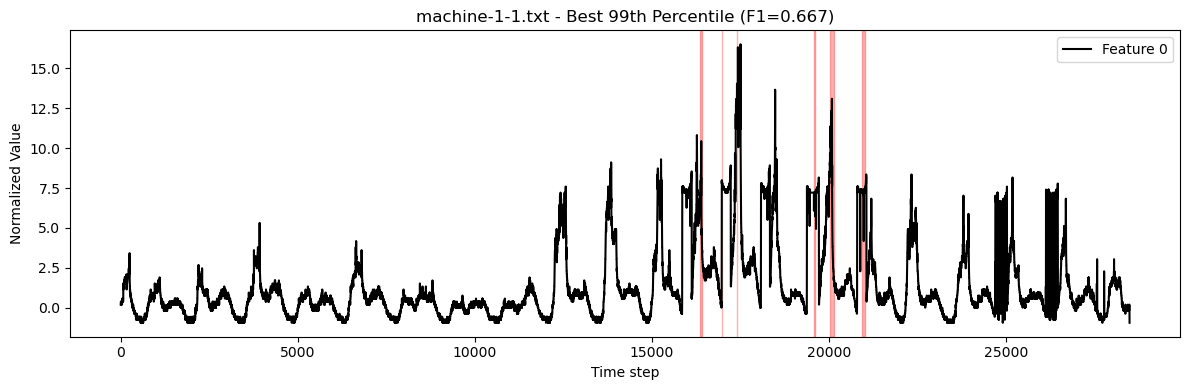

machine-1-2.txt | Best Threshold = 90th | F1 = 0.372
[Info] Detected teacher output dimension: 768
Detected 38 anomaly intervals.


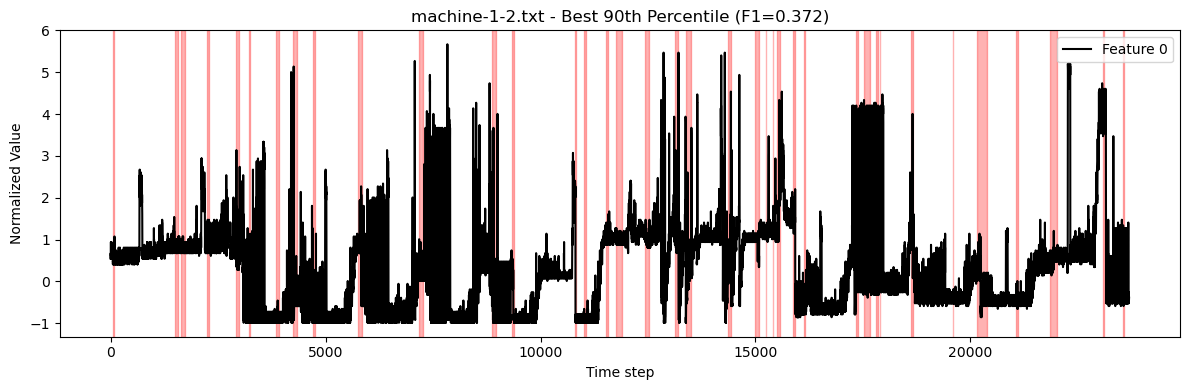

machine-1-3.txt | Best Threshold = 90th | F1 = 0.000
[Info] Detected teacher output dimension: 768
Detected 24 anomaly intervals.


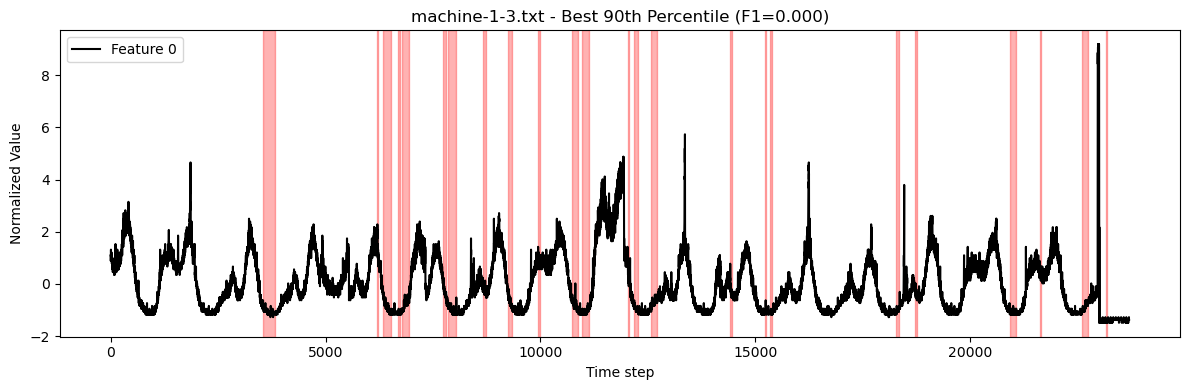

machine-1-4.txt | Best Threshold = 90th | F1 = 0.044
[Info] Detected teacher output dimension: 768
Detected 29 anomaly intervals.


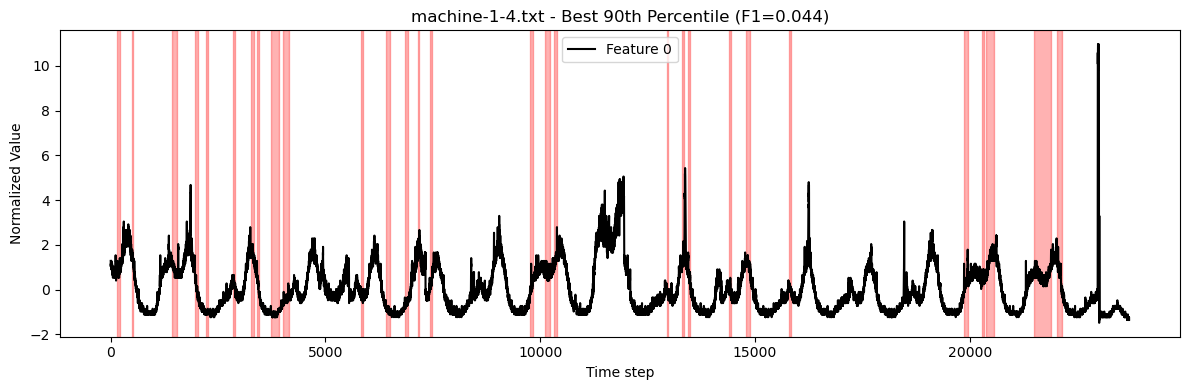

machine-1-5.txt | Best Threshold = 99th | F1 = 0.167
[Info] Detected teacher output dimension: 768
Detected 5 anomaly intervals.


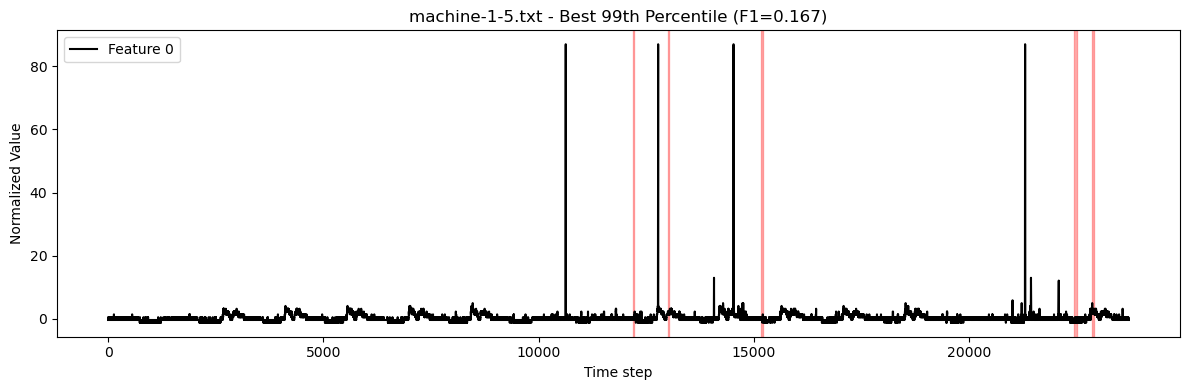

machine-1-6.txt | Best Threshold = 90th | F1 = 0.107
[Info] Detected teacher output dimension: 768
Detected 31 anomaly intervals.


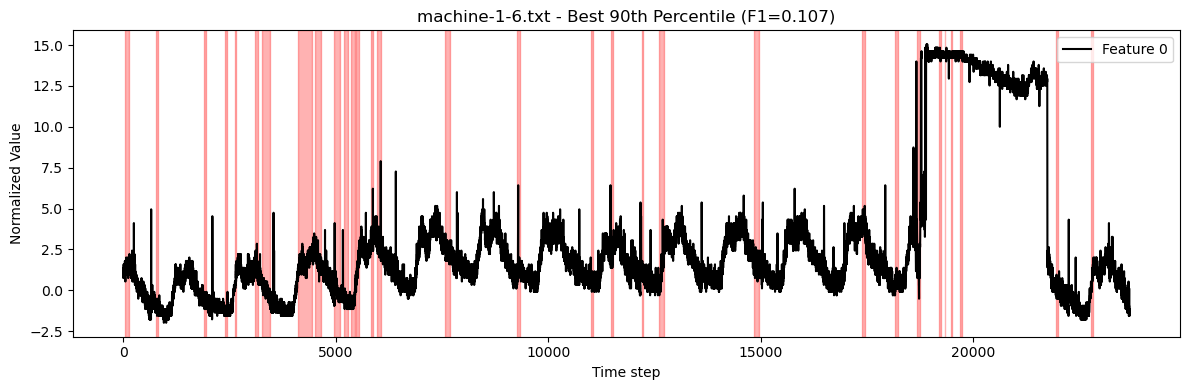

machine-1-7.txt | Best Threshold = 90th | F1 = 0.387
[Info] Detected teacher output dimension: 768
Detected 28 anomaly intervals.


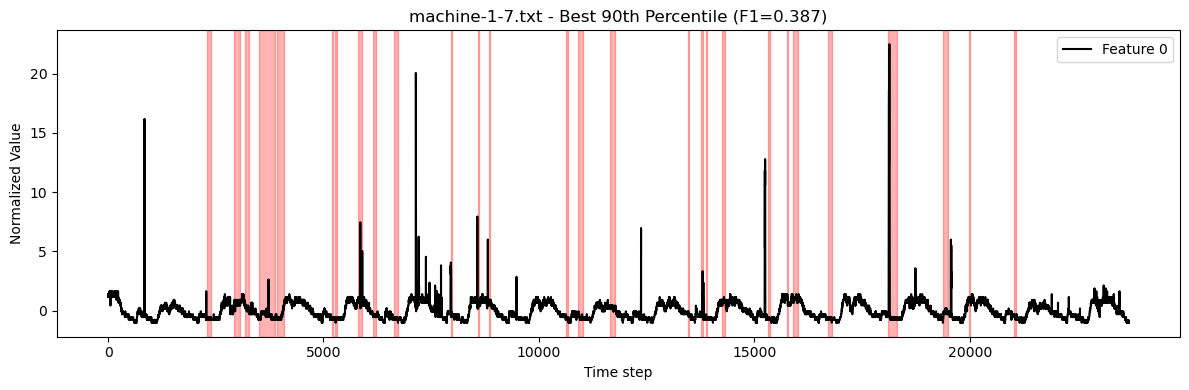

machine-1-8.txt | Best Threshold = 90th | F1 = 0.367
[Info] Detected teacher output dimension: 768
Detected 20 anomaly intervals.


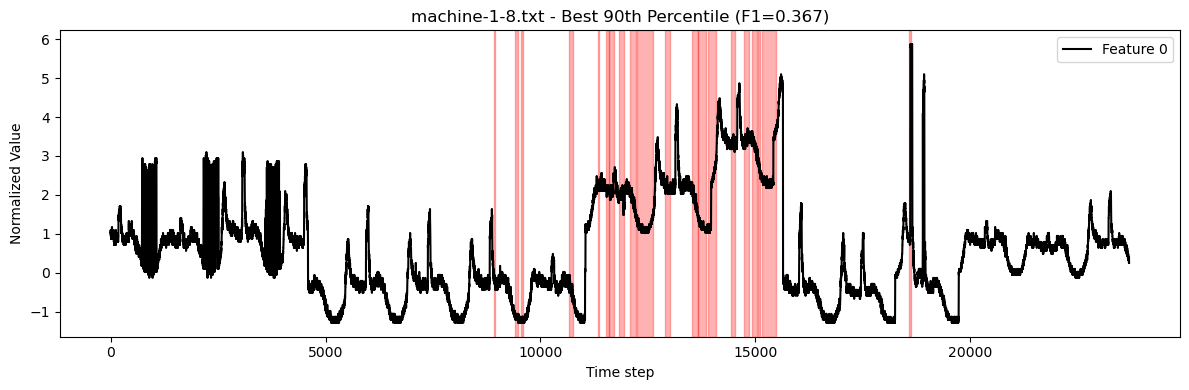

machine-2-1.txt | Best Threshold = 90th | F1 = 0.167
[Info] Detected teacher output dimension: 768
Detected 25 anomaly intervals.


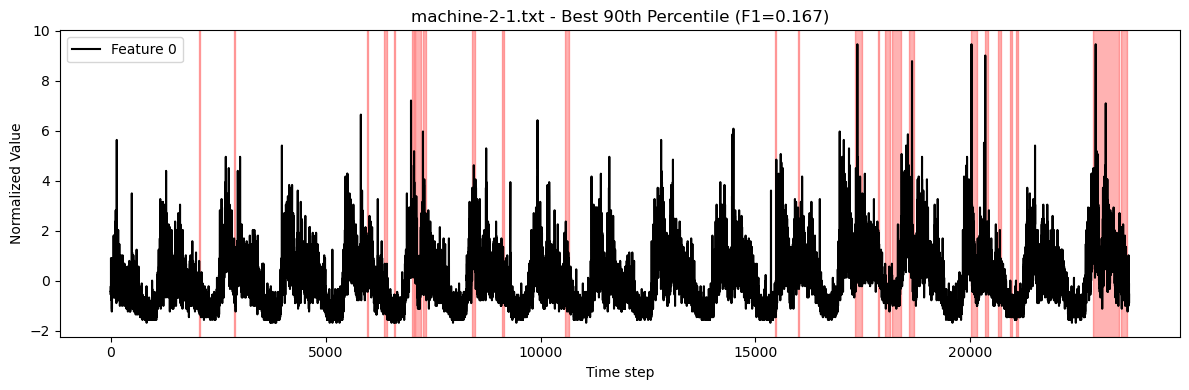

machine-2-2.txt | Best Threshold = 90th | F1 = 0.083
[Info] Detected teacher output dimension: 768
Detected 39 anomaly intervals.


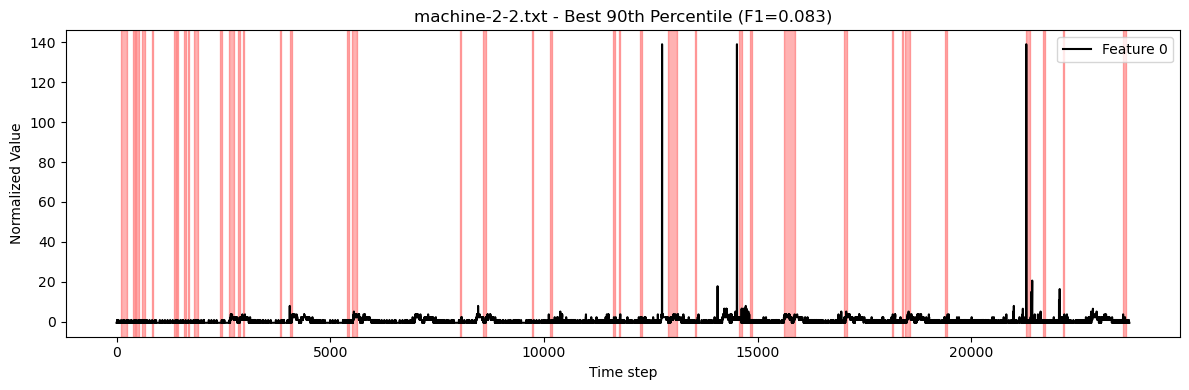

machine-2-3.txt | Best Threshold = 90th | F1 = 0.174
[Info] Detected teacher output dimension: 768
Detected 33 anomaly intervals.


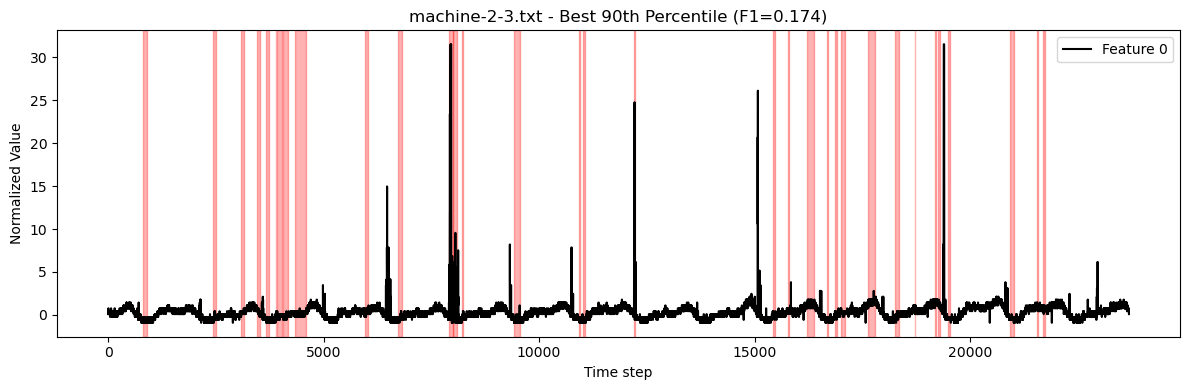

machine-2-4.txt | Best Threshold = 90th | F1 = 0.800
[Info] Detected teacher output dimension: 768
Detected 27 anomaly intervals.


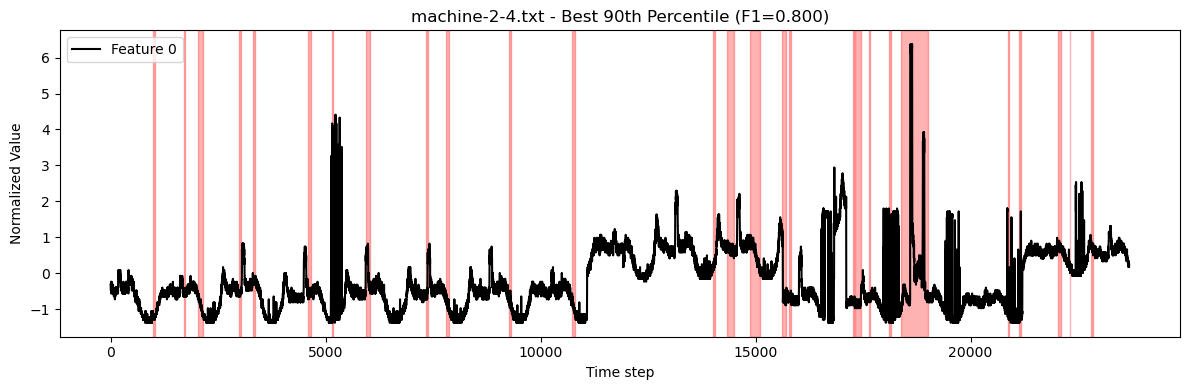

machine-2-5.txt | Best Threshold = 90th | F1 = 0.269
[Info] Detected teacher output dimension: 768
Detected 38 anomaly intervals.


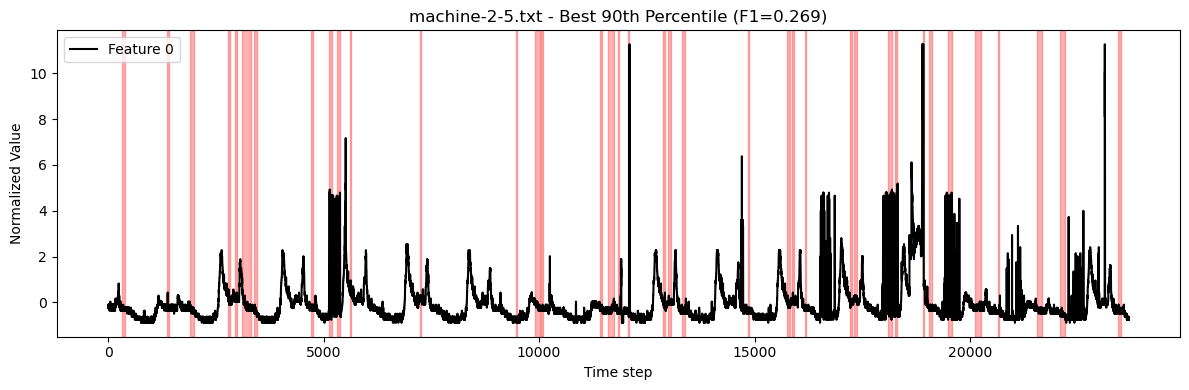

machine-2-6.txt | Best Threshold = 90th | F1 = 0.000
[Info] Detected teacher output dimension: 768
Detected 39 anomaly intervals.


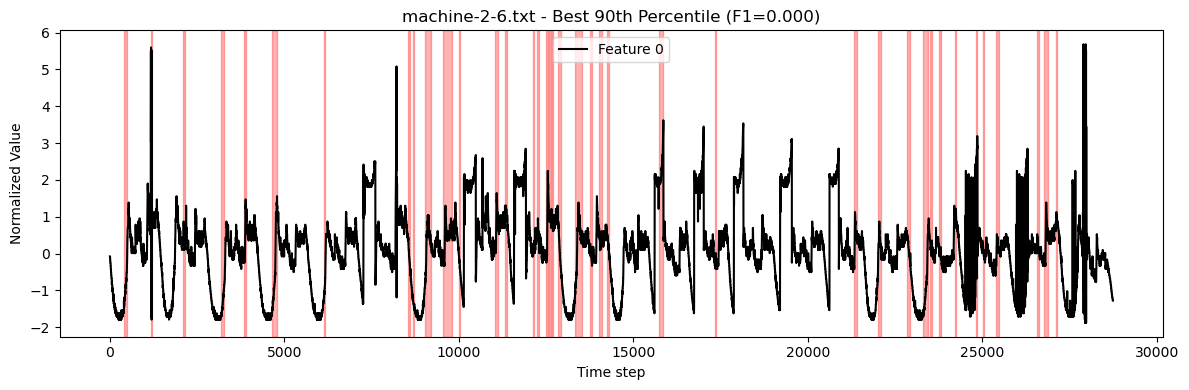

machine-2-7.txt | Best Threshold = 97th | F1 = 0.133
[Info] Detected teacher output dimension: 768
Detected 13 anomaly intervals.


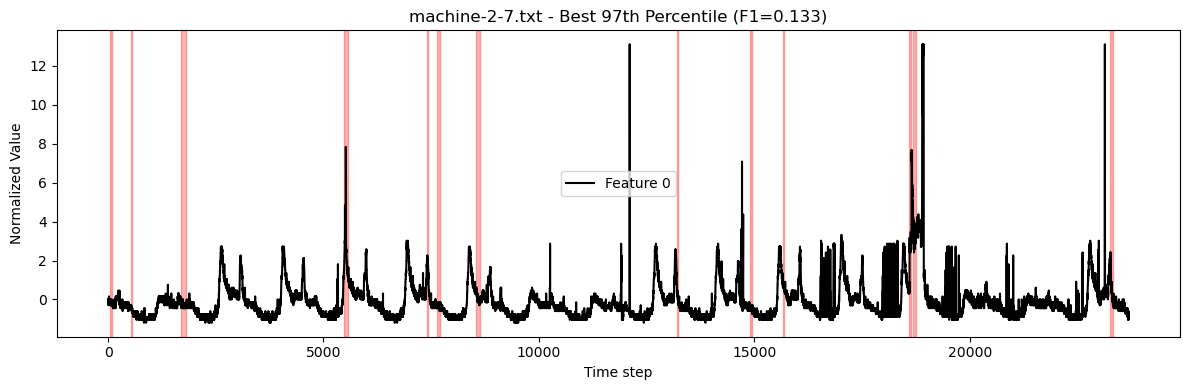


 Visualization complete for all files.


In [7]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt


if __name__ == "__main__":
    window_size = 128
    root = "ServerMachineDataset"
    train_dir = os.path.join(root, "train")
    test_dir = os.path.join(root, "test")
    model_dir = "checkpoints_exp4_layers6_SMD"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert to dictionary: {file_name: threshold}
    best_threshold_map = {f: th for f, th, _ in best_thresholds}

    print(f"Visualizing {len(best_threshold_map)} files using best thresholds...\n")

    for file_name, best_th, best_f1 in best_thresholds:
        print("=" * 80)
        print(f"{file_name} | Best Threshold = {best_th}th | F1 = {best_f1:.3f}")
        print("=" * 80)

        model_path = os.path.join(model_dir, file_name.replace(".txt", "_model.pth"))
        test_path = os.path.join(test_dir, file_name)
        train_path = os.path.join(train_dir, file_name)

        if not (os.path.exists(model_path) and os.path.exists(test_path) and os.path.exists(train_path)):
            print(f"Missing file(s) for {file_name}, skipping.")
            continue

        # Load data
        test_series = np.loadtxt(test_path, delimiter=',')
        train_series = np.loadtxt(train_path, delimiter=',')

        if train_series.ndim == 1:
            train_series = train_series[:, None]
        if test_series.ndim == 1:
            test_series = test_series[:, None]

        mean = train_series.mean(axis=0)
        std = train_series.std(axis=0) + 1e-8
        test_series = (test_series - mean) / std
        num_channels = test_series.shape[1]

        # Load model
        model = AnomalyLLMViT(
            window_size=window_size,
            num_channels=num_channels,
            stride=32,
            d_model=64,
            num_heads=8,
            num_layers=3,
            num_prototypes=32,
            patch_size=16
        ).to(device)

        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict, strict=False)
        model.eval()

        # Compute scores and threshold
        with torch.no_grad():
            scores = model.compute_anomaly_scores(test_series, device)
        threshold_value = np.percentile(scores, best_th)
        preds = (scores > threshold_value).astype(int)

        # Get contiguous anomaly intervals
        anomalies = []
        start = None
        for i, val in enumerate(preds):
            if val and start is None:
                start = i
            elif not val and start is not None:
                anomalies.append((start, i))
                start = None
        if start is not None:
            anomalies.append((start, len(preds)))

        print(f"Detected {len(anomalies)} anomaly intervals.")

        # Plot
        plt.figure(figsize=(12, 4))
        plt.plot(test_series[:, 0], label="Feature 0", color="black")
        for start, end in anomalies:
            plt.axvspan(start, end, color="red", alpha=0.3)
        plt.title(f"{file_name} - Best {best_th}th Percentile (F1={best_f1:.3f})")
        plt.xlabel("Time step")
        plt.ylabel("Normalized Value")
        plt.legend()
        plt.tight_layout()
        plt.show()

    print("\n Visualization complete for all files.")


In [15]:
import json
import os

best_results = []
for file_name, best_th, best_f1 in best_thresholds:
    # Find the metrics (P, R, F1) corresponding to the best threshold
    metrics_list = overall_metrics[best_th]
    idx = [f[0] for f in best_thresholds].index(file_name)
    if idx < len(metrics_list):
        p, r, f1 = metrics_list[idx]
    else:
        p = r = f1 = None  # fallback if mismatch occurs
    best_results.append({
        "file_name": file_name,
        "best_threshold": best_th,
        "precision": p,
        "recall": r,
        "f1": f1
    })

results = {"best_results": best_results}

os.makedirs("results", exist_ok=True)
save_path = os.path.join("results", "smd_eval_results.json")

with open(save_path, "w") as f:
    json.dump(results, f, indent=4)

print(f"\n Saved best-threshold evaluation results to {save_path}")


 Saved best-threshold evaluation results to results/smd_eval_results.json
